In [1]:
# import utils
import cv2
import os 
import sys
import matplotlib.pyplot as plt 
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import Resize, Compose, Normalize, HorizontalFlip, RandomBrightnessContrast
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import models, transforms

# import functions
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import *
from src.dataset_manager import *


In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_paths = sorted(list(Path(images_dir).glob("*.jpg")))
        self.mask_paths = sorted(list(Path(masks_dir).glob("*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Load image and mask
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # Normalize mask (binary: 0 or 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0

        return image, mask

In [3]:
# Training augmentations
train_transform = Compose(
    [
        HorizontalFlip(p=0.5),
        RandomBrightnessContrast(p=0.2),
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Resize(512, 512),  # Resize to 512x512 (adjust based on model input size)
        ToTensorV2(),
    ]
)

# Validation augmentations
val_transform = Compose(
    [
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        Resize(512, 512),
        ToTensorV2(),
    ]
)

In [4]:
train_images_dir = "../data/split/train/images"
train_masks_dir = "../data/split/train/masks"
val_images_dir = "../data/split/val/images"
val_masks_dir = "../data/split/val/masks"

train_dataset = SegmentationDataset(train_images_dir, train_masks_dir, transform=train_transform)
val_dataset = SegmentationDataset(val_images_dir, val_masks_dir, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [5]:
import torch
from segmentation_models_pytorch import Unet

# Define the U-Net model with the same configuration as during training
model = Unet(
    encoder_name="resnet34",  # Encoder backbone
    encoder_weights=None,    # No pretraining needed when loading weights
    in_channels=3,           # Input channels (RGB)
    classes=1,               # Output channels (binary segmentation)
)

# Load the model weights
model_path = "../checkpoints/best_model.pth"  # Path to the saved model
state_dict = torch.load(model_path, map_location=torch.device("cpu"))  # Load weights
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")



Model loaded successfully!


In [6]:
import numpy as np
import torch
from scipy.spatial.distance import directed_hausdorff

def compute_metrics(model, dataloader):
    model.eval()
    iou_scores = []
    dice_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    hausdorff_distances = []
    mae_scores = []

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            # Compute metrics for each sample
            for pred, mask in zip(preds, masks):
                intersection = (pred * mask).sum().item()
                pred_sum = pred.sum().item()
                mask_sum = mask.sum().item()
                union = pred_sum + mask_sum - intersection

                # IoU
                iou = intersection / (union + 1e-6)
                iou_scores.append(iou)

                # Dice
                dice = 2 * intersection / (pred_sum + mask_sum + 1e-6)
                dice_scores.append(dice)

                # Precision and Recall
                tp = intersection
                fp = pred_sum - intersection
                fn = mask_sum - intersection
                precision = tp / (tp + fp + 1e-6)
                recall = tp / (tp + fn + 1e-6)
                precision_scores.append(precision)
                recall_scores.append(recall)

                # F1 Score
                f1 = 2 * precision * recall / (precision + recall + 1e-6)
                f1_scores.append(f1)

                 # Mean Absolute Error (MAE)
                mae = torch.abs(pred - mask).mean().item()
                mae_scores.append(mae)

                # Hausdorff Distance
                pred_indices = torch.nonzero(pred, as_tuple=False).cpu().numpy()
                mask_indices = torch.nonzero(mask, as_tuple=False).cpu().numpy()
                if len(pred_indices) > 0 and len(mask_indices) > 0:
                    hd = max(
                        directed_hausdorff(pred_indices, mask_indices)[0],
                        directed_hausdorff(mask_indices, pred_indices)[0],
                    )
                else:
                    hd = float("inf")  # Handle case with empty prediction or mask
                hausdorff_distances.append(hd)

    

    # Calculate mean metrics
    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_f1 = np.mean(f1_scores)
    mean_mae = np.mean(mae_scores)
    #mean_hausdorff = np.mean(hausdorff_distances)
    mean_hausdorff = np.mean([d for d in hausdorff_distances if d != float("inf")])


    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice: {mean_dice:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1-Score: {mean_f1:.4f}")
    print(f"Mean MAE: {mean_mae:.4f}")
    print(f"Mean Hausdorff Distance: {mean_hausdorff:.4f}")

    return {
        "iou": mean_iou,
        "dice": mean_dice,
        "precision": mean_precision,
        "recall": mean_recall,
        "f1": mean_f1,
        "mae": mean_mae,
        "hausdorff": mean_hausdorff,
    }

device='cpu'
# Evaluate on the test set
test_images_dir = "../data/split/test/images"
test_masks_dir = "../data/split/test/masks"
test_dataset = SegmentationDataset(
    test_images_dir, test_masks_dir, transform=val_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# Evaluate on the test set
metrics = compute_metrics(model, test_loader)


C:\Users\yushe\AppData\Local\Temp\ipykernel_8316\2161048088.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0


Mean IoU: 0.7429
Mean Dice: 0.8439
Mean Precision: 0.9664
Mean Recall: 0.7579
Mean F1-Score: 0.8439
Mean MAE: 0.0062
Mean Hausdorff Distance: 28.2093


C:\Users\yushe\AppData\Local\Temp\ipykernel_8316\2161048088.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0) / 255.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5998802..2.6399999].


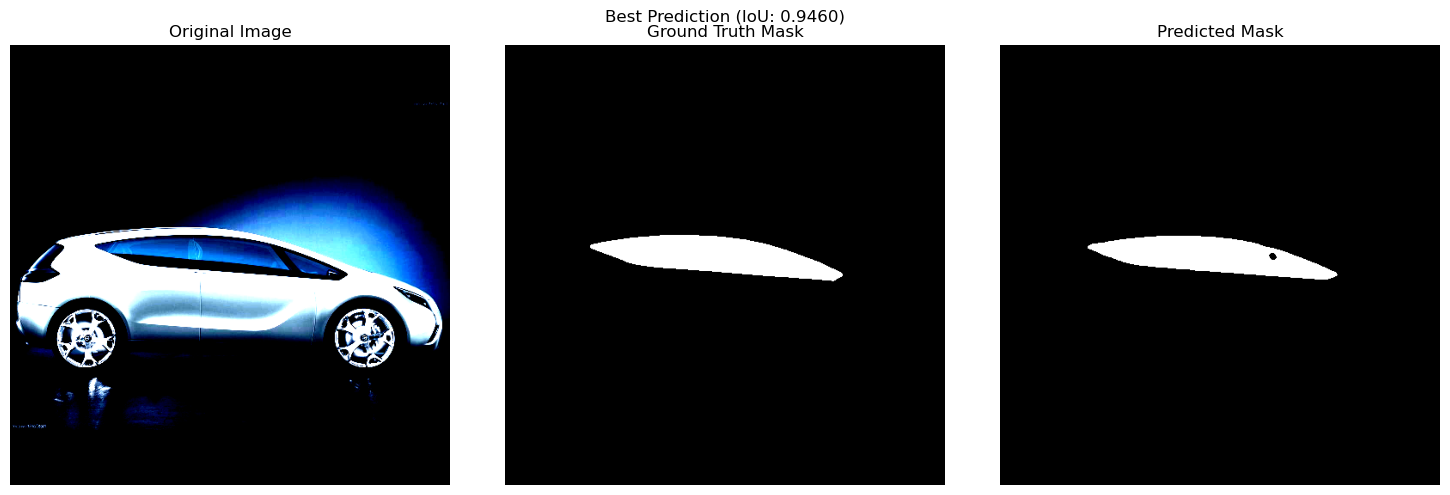

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.52671].


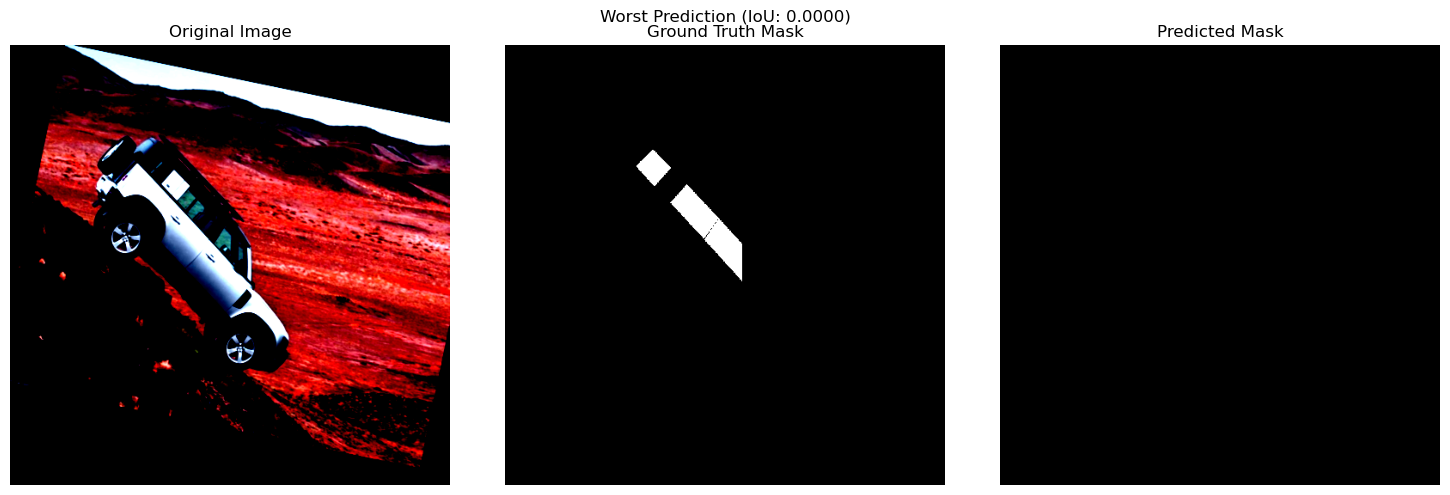

In [9]:
def find_best_and_worst_predictions_unet(model, dataloader):
    """
    Evaluate U-Net model on the test dataset and find the best and worst predictions.
    Args:
        model: U-Net model.
        dataloader: DataLoader for the test dataset.
    Returns:
        None (displays the best and worst predictions with their masks).
    """
    model.eval()
    best_iou = -float("inf")
    worst_iou = float("inf")
    best_data = None
    worst_data = None

    with torch.no_grad():
        for idx, (images, ground_truth_mask) in enumerate(dataloader):
            # Move data to the device
            images, ground_truth_mask = images.to(device), ground_truth_mask.to(device)

            # Predict using U-Net
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > 0.5).float()  # Binarize predictions

            # Compute IoU for each image in the batch
            for i in range(images.size(0)):
                pred = preds[i]
                gt_mask = ground_truth_mask[i]

                intersection = (pred * gt_mask).sum().item()
                union = (pred + gt_mask).sum().item() - intersection
                iou = intersection / (union + 1e-6)

                # Update best and worst predictions
                if iou > best_iou:
                    best_iou = iou
                    best_data = (images[i], pred, gt_mask, idx, iou)

                if iou < worst_iou:
                    worst_iou = iou
                    worst_data = (images[i], pred, gt_mask, idx, iou)

    # Display results
    display_prediction("Best Prediction", best_data)
    display_prediction("Worst Prediction", worst_data)


def display_prediction(title, data):
    """
    Display a single prediction with ground truth and mask.
    Args:
        title: Title of the display (e.g., 'Best Prediction').
        data: Tuple containing image, prediction mask, ground truth mask, index, and IoU.
    Returns:
        None (displays the image with masks).
    """
    if data is None:
        print(f"No {title} found.")
        return

    image, prediction_mask, ground_truth_mask, idx, iou = data
    # Convert image to numpy and scale to [0, 255]
    image_np = image.cpu().numpy().transpose(1, 2, 0)  # Convert CHW to HWC
    #image_np = (image_np * 255).astype(np.uint8)  # Scale to 0-255 for display

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{title} (IoU: {iou:.4f})")

    # Display original image
    plt.subplot(1, 3, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis("off")

    # Display ground truth mask
    plt.subplot(1, 3, 2)
    gt_mask_np = ground_truth_mask.squeeze().cpu().numpy()  # Remove channel dimension if present
    plt.imshow(gt_mask_np, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Display predicted mask
    plt.subplot(1, 3, 3)
    pred_mask_np = prediction_mask.squeeze().cpu().numpy()  # Remove channel dimension if present
    plt.imshow(pred_mask_np, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


test_images_dir = "../data/split/test/images"
test_masks_dir = "../data/split/test/masks"
test_dataset = SegmentationDataset(
    test_images_dir, test_masks_dir, transform=val_transform
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
# Evaluate and display best/worst predictions
find_best_and_worst_predictions_unet(model, test_loader)
